In [1]:
from sklearn.metrics import confusion_matrix
import torch
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#import models
import numpy as np

#model
import torch.nn as nn

MAXEPOCH=100
BATCH=1


In [2]:
class CNN(nn.Module):
    def __init__(self, nlayer=4, dropout=0.1):
        super().__init__()
        layers = []

        drop = torch.nn.Dropout(p=dropout)
        conv1 = torch.nn.Conv1d(21,32,3,padding=1) # aa1hot,channel,
        layers = [drop,conv1]
        
        for k in range(nlayer):
            conv2 = torch.nn.Conv1d(32,32,3,padding=1) # aa1hot,channel,
            layers.append(conv2)
            layers.append(nn.BatchNorm1d(32))
            layers.append(nn.ReLU(inplace=True))

        self.layers = nn.ModuleList(layers)

        # 1 x 32 x nres
        self.outlayer = nn.Linear(32,3)
        
    def forward(self, seq):
        #pred = seq # should B x 20 x nres
        for layer in self.layers:
            seq = layer(seq)

        seq = torch.transpose(seq,1,2) # put channel at the last
        
        pred = self.outlayer(seq)
        pred = torch.transpose(pred,2,1)
        return pred

In [3]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, datalist): #idx제거
        self.tags = [tag for tag in datalist if not tag.endswith('.DS_Store')]

    def __len__(self):
        return len(self.tags)

    def __getitem__(self,index):
        npz = self.tags[index]
        #print(npz)
          
        data = np.load(npz,allow_pickle=True)

        aas = 'ACDEFGHIKLMNPQRSTVWYX'
        SS3 = 'HEC'
    
        seqs = [aas.index(a) for a in  data['sequence']]#변수 명 바꿈
        #print(seqs)
        SSs  = [SS3.index(a) for a in data['SS']]
        
        seq1hot = np.transpose(np.eye(21)[seqs],(1,0)) # 20xnres #tensor size 20으로 바꿈.
        #np.eye(21)[seqs]=> 21x21항등행렬을 만드는데 seqs에 맞게 설정된 항등행렬을 만들어라.
        
        SS1hot = np.transpose(np.eye(3)[SSs],(1,0)) #np.eye는 항등행렬을 생성해줌
        #print(SS1hot)
        return seq1hot, SSs, seq1hot.shape[1] #SSs[index]??->SS1hot
        #seq1hot.shape[1]=시퀀스의 길이다.

In [4]:
def collate(samples): # 같은 배치 안에 길이가 가장 긴 input에 맞춰 다른 input들에 임의로 zero-padding.
    seq,SS,nres = map(list, zip(*samples))
    valid = [i for i,n in enumerate(nres) if n > 50]
    #print(valid)
    if len(valid) == 0: return [],[]
    
    seq = [seq[i] for i in valid]
    SS = [SS[i] for i in valid]
    
    nres = max(nres)
    B = len(seq)

    # map into maxres
    seqs = torch.zeros(B,21,nres)
    #print(seqs)
    SSs  = torch.zeros(B,nres,dtype=torch.long)
    for i,s in enumerate(seq): #seqs는 0한 개로만 이루어진 리스트다. 때문에 i는 0만 출력된다.
        #print(i)
        seqs[i][:len(s[1])] = torch.tensor(s) 
    for i,s in enumerate(SS): 
        #print(i)
        SSs[i][:len(s)] = torch.tensor(s)

    return seqs, SSs

In [5]:
model = CNN()
model.to(device)

## load dataset
trainlist = np.load('train.npy')
validlist = np.load('valid.npy')

trainset = DataSet(trainlist)
validset = DataSet(validlist)

generator_params = {
    'shuffle': True,
    'num_workers': 0, #num_worker 오류가 나서 0으로 바꿔줌.
    'pin_memory': True,
    'collate_fn': collate,
    'batch_size': BATCH,
    'worker_init_fn' : np.random.seed()
}
train_generator = torch.utils.data.DataLoader(trainset, **generator_params)
valid_generator = torch.utils.data.DataLoader(validset, **generator_params)
 
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

lossfunc = torch.nn.CrossEntropyLoss()
for epoch in range(MAXEPOCH):  #seq를 보고 이차구조(SS)를 예측하는 것이 goal
    loss_t = []
    for i,(seq,SS) in enumerate(train_generator):
        if len(seq) == 0: continue
        
        # get prediction
        SSpred = model(seq.to(device))
        optimizer.zero_grad()
        # calculate loss
        SS = SS.to(device)
        loss = lossfunc(SSpred,SS)
        loss.backward(retain_graph=True)
        optimizer.step()

        loss_t.append(loss.cpu().detach().numpy())
    #print("TRAIN:", epoch, float(np.mean(loss_)))
        
    loss_v = []
    for i,(seq,SS) in enumerate(valid_generator):
        if len(seq) == 0: continue        
        # get prediction
        SSpred = model(seq.to(device))
        SS_valid=SSpred
        
        # calculate loss
        SS = SS.to(device)
        loss = lossfunc(SSpred,SS)
        loss_v.append(loss.cpu().detach().numpy())
        
    print("Train/Valid: %3d %8.4f %8.4f"%(epoch, float(np.mean(loss_t)), float(np.mean(loss_v))))

Train/Valid:   0   0.9950   0.9667
Train/Valid:   1   0.9421   0.9322
Train/Valid:   2   0.9253   0.9314
Train/Valid:   3   0.9048   0.9120
Train/Valid:   4   0.8915   0.9048
Train/Valid:   5   0.8727   0.8907
Train/Valid:   6   0.8613   0.8842
Train/Valid:   7   0.8499   0.8801
Train/Valid:   8   0.8380   0.8693
Train/Valid:   9   0.8342   0.8666
Train/Valid:  10   0.8203   0.8676
Train/Valid:  11   0.8124   0.8654
Train/Valid:  12   0.7964   0.8586
Train/Valid:  13   0.7868   0.8425
Train/Valid:  14   0.7794   0.8327
Train/Valid:  15   0.7689   0.8386
Train/Valid:  16   0.7614   0.8323
Train/Valid:  17   0.7507   0.8334
Train/Valid:  18   0.7469   0.8224
Train/Valid:  19   0.7420   0.8279
Train/Valid:  20   0.7249   0.8090
Train/Valid:  21   0.7211   0.8168
Train/Valid:  22   0.7152   0.8302
Train/Valid:  23   0.7036   0.8032
Train/Valid:  24   0.6988   0.8171
Train/Valid:  25   0.7024   0.8127
Train/Valid:  26   0.6944   0.7917
Train/Valid:  27   0.6935   0.8399
Train/Valid:  28   0

In [6]:
correct_train=0
total_train=0
for i, (seq, SS) in enumerate(train_generator):

    if len(seq)==0:
        continue
    #print(seq)
    SSpred=model(seq.to(device))

    predicted = torch.argmax(SSpred.data,1)

    correct_train += torch.sum(predicted == SS.to(device)).item()

    SS_squeeze=SS.squeeze()
    SS_squeeze_1=SS_squeeze.squeeze()
    total_train+=SS_squeeze_1.size(0)

accuracy_train=correct_train/total_train  
print(accuracy_train*100)

72.71900336167688


In [7]:
correct_valid=0
total_valid=0
for i, (seq, SS) in enumerate(valid_generator):

    if len(seq)==0:
        continue
    #print(seq)
    SSpred=model(seq.to(device))

    predicted = torch.argmax(SSpred.data,1)

    correct_valid += torch.sum(predicted == SS.to(device)).item()

    SS_squeeze=SS.squeeze()
    SS_squeeze_1=SS_squeeze.squeeze()
    total_valid+=SS_squeeze_1.size(0)

accuracy_valid=correct_valid/total_valid  
print(accuracy_valid*100)

67.58203301906212


In [8]:
#confusion matrix-train_set
for i, (seq, SS) in enumerate(train_generator):
    if len(seq)==0:
        continue
    
    SSpred=model(seq.to(device))
    
    predicted = torch.argmax(SSpred.data,dim=1)
    
    cm=confusion_matrix(SS.to(device).detach().numpy().flatten(), predicted.detach().numpy().flatten())


[[15792  2135  3302]
 [ 1808 29545  8139]
 [ 2428  9888 28103]]



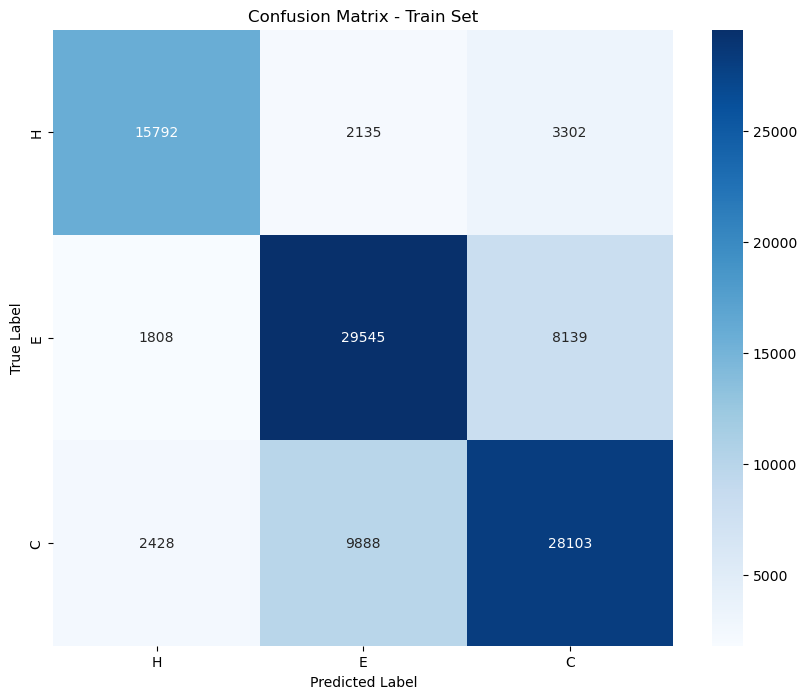

In [9]:
#concat confusion matrix-train_set
import matplotlib.pyplot as plt
import seaborn as sns
SS_concat=[]
predicted_concat=[]
for i, (seq, SS) in enumerate(train_generator):
    if len(seq)==0:
        continue
    SS=SS.to(device)
    SS_concat.append(SS)
    SSpred=model(seq.to(device))
    predicted = torch.argmax(SSpred.data,dim=1)
    predicted_concat.append(predicted)
SS_concat_tensor=torch.cat(SS_concat,dim=1)
predicted_concat_tensor=torch.cat(predicted_concat,dim=1)
cm=confusion_matrix(SS_concat_tensor.detach().numpy().flatten(), predicted_concat_tensor.detach().numpy().flatten())
print(cm)
print()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train Set')
plt.show()


In [10]:
#confusion matrix-test_set
for i, (seq, SS) in enumerate(valid_generator):
    if len(seq)==0:
        continue
    
    SSpred=model(seq.to(device))
    
    predicted = torch.argmax(SSpred.data,dim=1)
    
    cm=confusion_matrix(SS.to(device).detach().numpy().flatten(), predicted.detach().numpy().flatten())


[[2805  947 1077]
 [ 539 6833 2074]
 [ 778 2631 6605]]



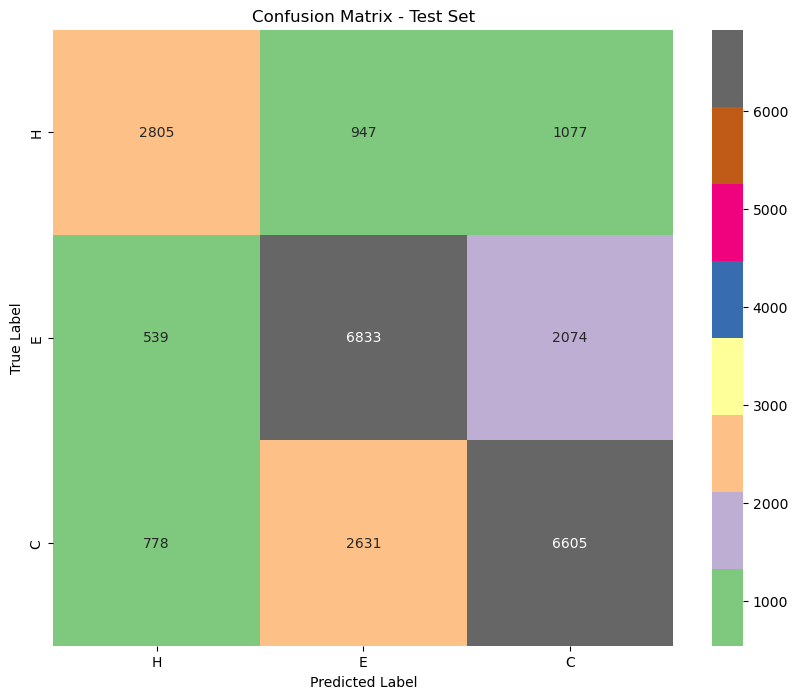

In [11]:
#concat confusion matrix-test_set
SS_concat=[]
predicted_concat=[]
for i, (seq, SS) in enumerate(valid_generator):
    if len(seq)==0:
        continue
    SS=SS.to(device)
    SS_concat.append(SS)
    SSpred=model(seq.to(device))
    predicted = torch.argmax(SSpred.data,dim=1)
    predicted_concat.append(predicted)
SS_concat_tensor=torch.cat(SS_concat,dim=1)
#print(SS_concat_tensor)
predicted_concat_tensor=torch.cat(predicted_concat,dim=1)
#print(predicted_concat_tensor)
cm=confusion_matrix(SS_concat_tensor.detach().numpy().flatten(), predicted_concat_tensor.detach().numpy().flatten())
print(cm)
print()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Accent', fmt='g', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()